# Exploring Instagram User Behavior: Analysis of Posts, Profiles, and Business Account Information

### By Team 5: Amit Pawar, Jinwen Zhang, Weiming Wang, Xiaoqing Yang, Zi Yuan Li

## Instagram Background:

Instagram (INSTAnt + teleGRAM) was founded in 2010 by Kevin Systrom and Mike Krieger as a mobile application for photo-sharing. 

It got acquired by Facebook in 2012 for $1B in cash and stocks. 

Instagram provides a platform for social media users to share their videos (in the form of short reels) with their followers. Other key features include hashtags, stories, geolocation tagging, and "co-watching." On the business side, Instagram has been a more sought-after advertisement platform for small and medium-scale businesses for its reachability. 

Instagram also provides specific APIs for businesses to integrate and use Instagram. 

## Data Source:
https://www.kaggle.com/datasets/shmalex/instagram-dataset

## Motivation:

Subscribers play an essential role in Instagram's business because, as a free platform, the subscribers are the product. As a result, Instagram must keep all sorts of essential metrics to measure its health as a social media platform. Monthly Average Users and Daily Average Users are also critical metrics in their income statements.

As a powerful means of advertisement, Instagram must keep a close eye on subscriber frequency. Creating user categories and feeding users more attractive and "targetted" data is one ingredient to maintain subscriber stickiness. On the other hand, it must also create appropriate customer segments for the businesses to advertise their products to the proper categories more effectively. 

We, as a team, wanted to explore some of these critical metrics regarding subscriber segmentation and stickiness spread across geographic regions. 

## Data Preparation

The original data source provided three csv files. We uploaded them to GCS and used BigQuery to perform some preprocessing tasks on the data. The code we used are as below:

In [ ]:
#CREATE TABLE `is843-team-project-5.IS843P5.posts_cleaned` AS
#SELECT * FROM `is843-team-project-5.IS843P5.posts` WHERE sid_profile != -1 and cts > '2018-08-30 11:36:08 UTC'

#CREATE or REPLACE TABLE `is843-team-project-5.IS843P5.t2_data` AS
#SELECT post_id,P.profile_id,location_id,P.cts as post_time,post_type,P.description as post_description,numbr_likes,number_comments,name as location_name,blurb as location_description,dir_city_name as city,dir_country_name as country,lat,lng
#profile_name,PF.description as profile_description,PF.following,followers,n_posts,is_business_account
#FROM `is843-team-project-5.IS843P5.posts_cleaned` P
#LEFT JOIN `is843-team-project-5.IS843P5.location` L
#ON P.location_id = L.id
#LEFT OUTER JOIN `is843-team-project-5.IS843P5.profile` PF
#ON P.profile_id = PF.profile_id 

The three tables are locations, posts and profile, altogether more than 12 GB and 44 columns. We first did some cleaning for the posts tables. By preliminary analysis we found that more than 80% of the records range from 2018 to 2019, and only few sparsely distributed between the previous 10 years. To facilitate our future analysis (such as month distribution related questions) and also reduce our sample size a bit, we only selected the records after 2018-08-30. Meanwhile, we got rid of the records with a sid_profile equals to -1 which are simply meaningless. Those steps correspond to the first table 'posts_cleaned' we created.

Next, we selected 20 columns that are useful to our analysis from posts_cleaned, location and profile. We used posts_cleaned as the main table, conducted two left joins to join the other two tables together, with location_id and profile_id as the keys. We didn't drop all the nulls because it would significantly reduce our sample size, and we would take care of the nulls for specific columns in our analysis about those columns later. Our final table is called 'merged_cleaned_data', and we would directly read it from BigQuery for the subsequent analysis, and here is the attributes description:

| Attributes     | Description |
| ----------- | ----------- |
| post_id      | Post ID      |
| profile_id   | Instagrams ID      |
| location_id      | Location ID      |
| post_time      | Timestamp when the Post was created      |
| post_type      | 1 - Photo, 2 - Video, 3 - multy      |
| post_description      | A brief description of the Post      |
| numbr_likes      | Number of Likes at the moment it was visited      |
| number_comments | Number of Likes at the moment it was visited |
| location_name |Name of location where the Post was created|
| location_description| A short description of the location|
| city| City name|
| country |Country name|
| lat |latitude|
| lng| longtitude|
| profile_name |Name of the profile|
| profile_description|Instagram bio|
| following |Number of following|
| followers |Number of followers|
| n_posts |Number of posts|
| is_business_account| equals to 1 if it is a business account, equals to 0 otherwise|

## Common Code

In [8]:
# Defining all libraries.
!pip install wordcloud
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 8.4 MB/s eta 0:00:00a 0:00:01


In [9]:
# Reading data from BigQuery

df = spark.read.format('bigquery') \
  .option('table', 'is843-team-project-5.IS843P5.merged_cleaned_data') \
  .load()

In [10]:
# Printing schema

df.printSchema()

root
 |-- post_id: string (nullable = true)
 |-- profile_id: long (nullable = true)
 |-- location_id: long (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- post_type: long (nullable = true)
 |-- post_description: string (nullable = true)
 |-- numbr_likes: long (nullable = true)
 |-- number_comments: long (nullable = true)
 |-- location_name: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- profile_name: string (nullable = true)
 |-- profile_description: string (nullable = true)
 |-- following: long (nullable = true)
 |-- followers: long (nullable = true)
 |-- n_posts: long (nullable = true)
 |-- is_business_account: boolean (nullable = true)



In [11]:
# Putting the data into cache for easy and quick access
df.cache()

DataFrame[post_id: string, profile_id: bigint, location_id: bigint, post_time: timestamp, post_type: bigint, post_description: string, numbr_likes: bigint, number_comments: bigint, location_name: string, location_description: string, city: string, country: string, lat: double, lng: double, profile_name: string, profile_description: string, following: bigint, followers: bigint, n_posts: bigint, is_business_account: boolean]

## A. Posts Based Analysis

### 1. Exploratary Data Analysis

#### i. Data Description 

In [12]:
df_Post = df
pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_Post.select(
    df_Post["numbr_likes"],
    df_Post["number_comments"]
).toPandas().describe()

,numbr_likes,number_comments
count,22804842,22804842
mean,316,9
std,7499,209
min,0,0
25%,20,0
50%,45,2
75%,106,5
max,8822952,313997


The summary statistics show that the numbr_likes and number_comments columns in the DataFrame are heavily skewed to the right, indicating that there are a few posts with a very large number of likes and comments that pull the mean and maximum values up. For example, the mean number of likes is only 316, but the maximum number of likes for a post is 8,822,952. Similarly, the mean number of comments is only 9, but the maximum number of comments for a post is 313,997. The large standard deviations also indicate a high degree of variability in the data.

In [8]:
from pyspark.sql.functions import col, sum

# Replace 'df' with the name of your DataFrame
null_counts = df_Post.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns))

# Calculate the percentage of null values in each column
null_counts_percent = null_counts.select(*((col(c) / df_Post.count() * 100).alias(c) for c in null_counts.columns))

null_counts_percent.toPandas()

,post_id,profile_id,location_id,post_time,post_type,post_description,numbr_likes,number_comments,location_name,location_description,city,country,lat,lng,profile_name,profile_description,following,followers,n_posts,is_business_account
0,0,8,45,0,0,9,0,0,52,52,77,77,52,52,8,9,9,9,9,9


The code above computes the percentage of missing data in the dataset. The degree of missing data can vary and may have an impact on the analysis

#### ii. Mapping the Top 100 Number of Likes and Number of Comments 

In [13]:
#!pip install folium

import folium
map = folium.Map(location=[0, 0], zoom_start=2)

# Filter out rows where either 'lat' or 'lng' is null and lat is between -85 and 85
filtered_df = df_Post.filter(col("lat").isNotNull() & col("lng").isNotNull() & (col("lat") <= 85) & (col("lat") >= -85))

# Get the top 700 rows by number of likes and comments
top_likes = filtered_df.sort(desc("numbr_likes")).limit(700).select("lat", "lng").collect()
top_comments = filtered_df.sort(desc("number_comments")).limit(700).select("lat", "lng").collect()

# Add a marker for each point with blue color for top 700 rows by number of likes
for row in top_likes:
    lat, lng = row["lat"], row["lng"]
    if lat and lng:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color="blue",
            fill=True,
            fill_color="blue"
        ).add_to(map)

# Add a marker for each point with red color for top 700 rows by number of comments
for row in top_comments:
    lat, lng = row["lat"], row["lng"]
    if lat and lng:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color="red",
            fill=True,
            fill_color="red"
        ).add_to(map)

# Display the map in the Jupyter Notebook
display(map)

![Example Image]( https://drive.google.com/uc?id=1e3ggyBHcKRRWZucnhjzWae2OCQ0YQDd0)

Due to a file trust issue, the picture above is a visual representation of an interactive Folium map that was created. The red dots on the map are plotted using the latitude and longitude of the top 700 posts with the highest number of comments, while the blue dots represent the top 700 posts with the highest number of likes. There is no clear geographical pattern; however, the dots are more likely to appear in places that are far away from ordinary people's lives, such as islands in the middle of the Atlantic Ocean and the South Pole. This finding is rational because users are more likely to like and comment on content that they rarely see in their lives

#### iii. Word Cloud of the Posts Decriptions of Posts with Top 10000 Number of Likes and Number of Comments

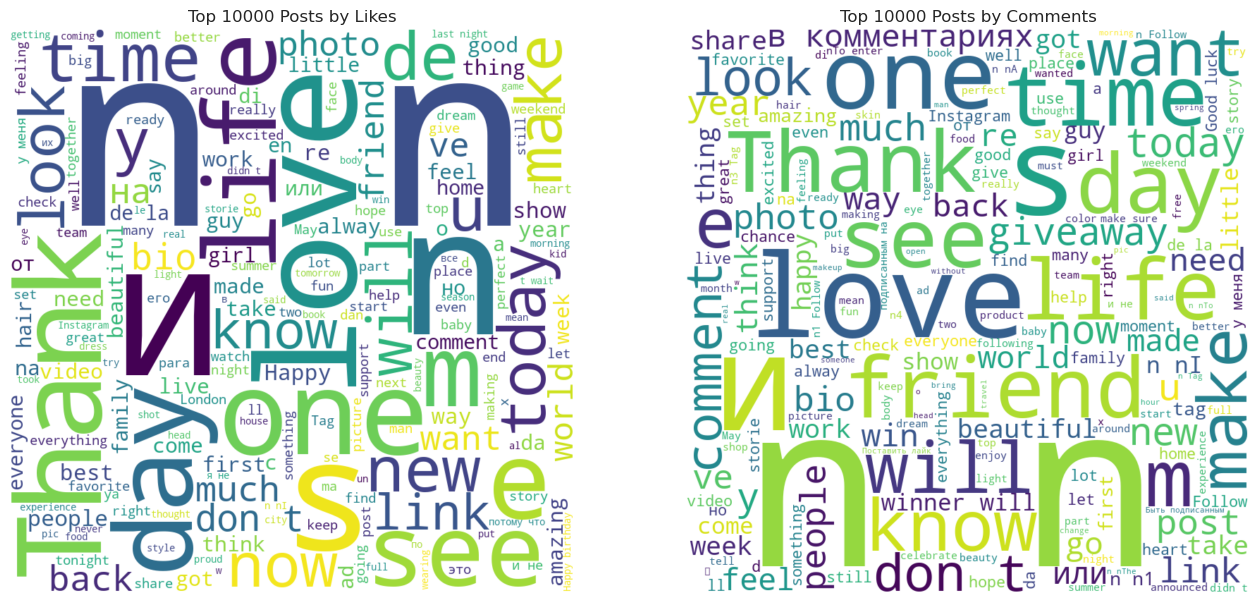

In [10]:
#!pip install wordcloud
# Filter the top 10000 posts with the highest number of likes and non-null descriptions
top_likes = df_Post.filter(df_Post.post_description.isNotNull()).orderBy("numbr_likes", ascending=False).limit(100000)

# Filter the top 10000 posts with the highest number of comments and non-null descriptions
top_comments = df_Post.filter(df_Post.post_description.isNotNull()).orderBy("number_comments", ascending=False).limit(100000)

# Get the descriptions as a single string
likes_descriptions = " ".join(top_likes.toPandas()["post_description"].tolist())
comments_descriptions = " ".join(top_comments.toPandas()["post_description"].tolist())

# Create the word clouds
likes_wordcloud = WordCloud(background_color="white", width=800, height=800).generate(likes_descriptions)
comments_wordcloud = WordCloud(background_color="white", width=800, height=800).generate(comments_descriptions)

# Set up the plotting style
sns.set(style="white")

# Display the word clouds side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(likes_wordcloud, interpolation="bilinear")
axs[0].set_title("Top 10000 Posts by Likes")
axs[0].axis("off")

axs[1].imshow(comments_wordcloud, interpolation="bilinear")
axs[1].set_title("Top 10000 Posts by Comments")
axs[1].axis("off")

plt.show()

The word clouds generated from the top 10,000 posts with the highest number of comments and the top 10,000 posts with the highest number of likes reveal a clear pattern in our dataset. The first finding shows that the most frequently used language in the top posts is not English. This may be due to limitations in the original dataset, such as missing values and the region when data scrapping was conducted. The second finding is that positive words such as love, thank, friend, and will have the highest frequencies. This finding is logical since such words can uplift people's moods

#### iv. Top 10 Average Number of Comments and Average Number of Likes per Country 

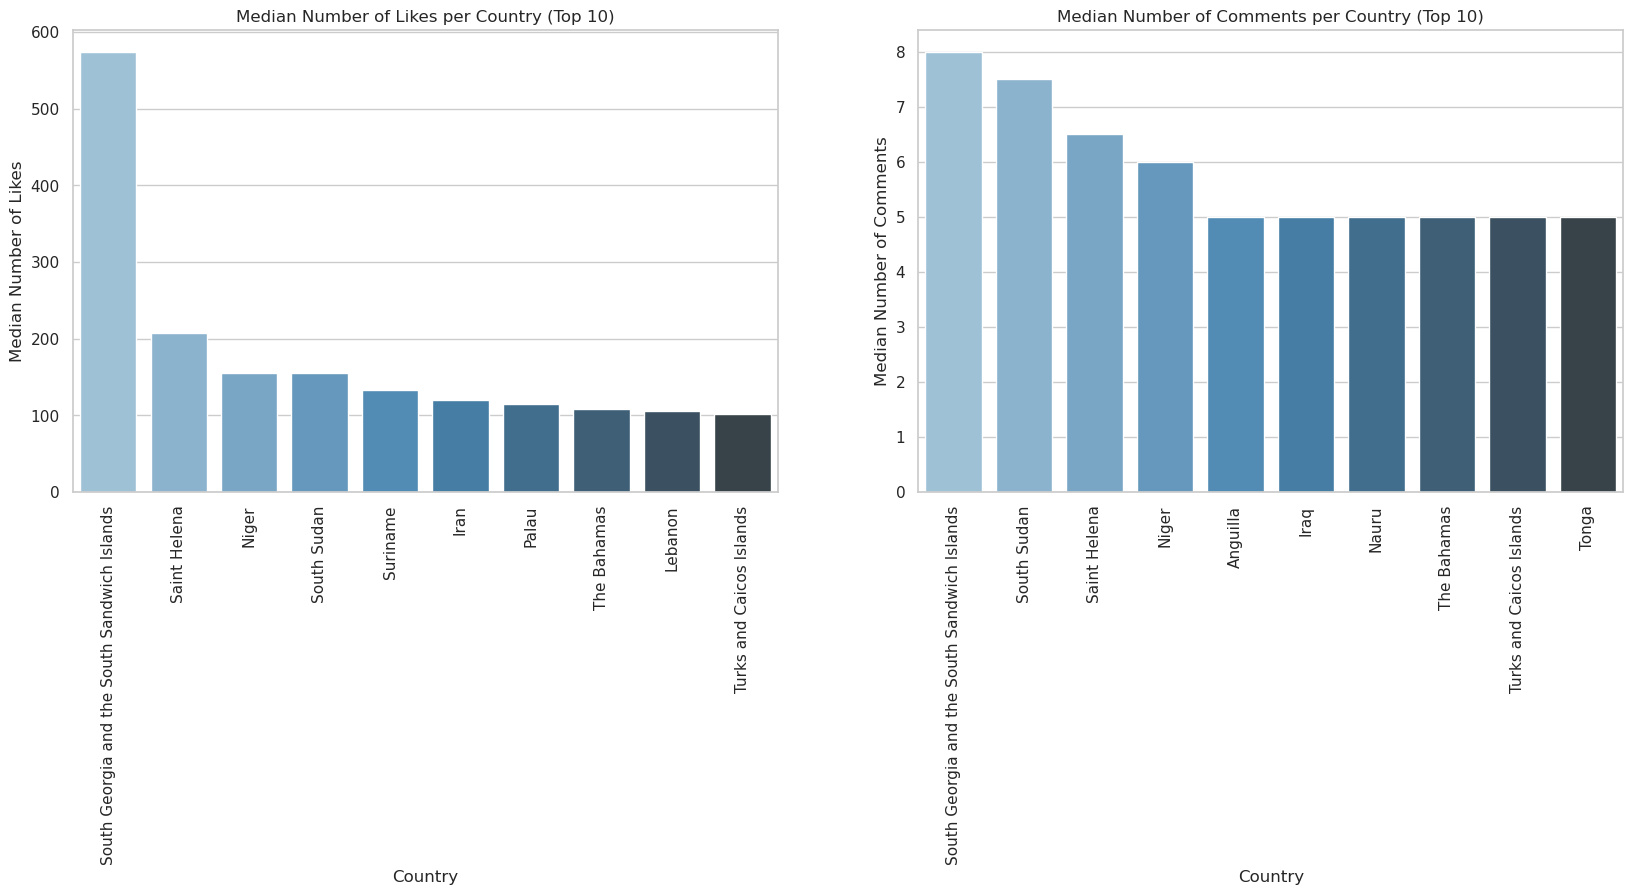

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, expr

# Group the posts by country and compute the median number of comments and likes
grouped_by_country = df_Post.groupBy("country") \
                       .agg(expr("percentile(numbr_likes, 0.5)").alias("median_likes"),
                            expr("percentile(number_comments, 0.5)").alias("median_comments"))

# Select the top 10 countries by median number of likes
top_likes = grouped_by_country.orderBy(desc("median_likes")).limit(10)

# Select the top 10 countries by median number of comments
top_comments = grouped_by_country.orderBy(desc("median_comments")).limit(10)

# Convert the grouped data to Pandas DataFrames
top_likes_pd = top_likes.toPandas()
top_comments_pd = top_comments.toPandas()

# Set up the plotting style
sns.set(style="whitegrid")

# Set up the side by side plots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot a bar chart for the median number of likes per country
sns.barplot(x="country", y="median_likes", data=top_likes_pd, palette="Blues_d", ax=axs[0])
axs[0].set_xlabel("Country")
axs[0].set_ylabel("Median Number of Likes")
axs[0].set_title("Median Number of Likes per Country (Top 10)")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# Plot a bar chart for the median number of comments per country
sns.barplot(x="country", y="median_comments", data=top_comments_pd, palette="Blues_d", ax=axs[1])
axs[1].set_xlabel("Country")
axs[1].set_ylabel("Median Number of Comments")
axs[1].set_title("Median Number of Comments per Country (Top 10)")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.show()


The above bar charts shows the countries with highest median number of likes and number of comments. We see some overlaping in two graph indicating the high correlation between number of likes and number of comments.Also, most of the countries are not located in North America. This may be due to limitations in the original dataset, such as missing values and the region when data scrapping was conducted.

#### v. Post Time vs. Nunmber of likes and comments

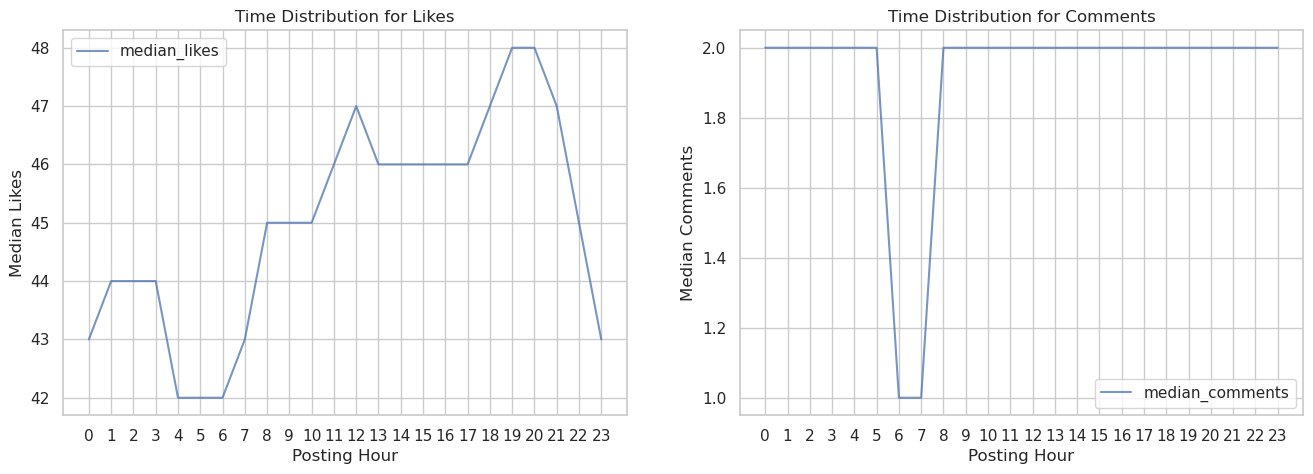

In [12]:
from pyspark.sql.functions import hour, col, expr

# Create a dataframe for posting hour, likes, and comments
time_like_comment = df.select(hour(col("post_time")).alias("post_hour"), 
                              col("numbr_likes").alias("number_likes"), 
                              col("number_comments"))

# Group by median likes and comments
time_grouped = time_like_comment.groupBy("post_hour") \
                                .agg(expr("percentile_approx(number_likes, 0.5)").alias("median_likes"), 
                                     expr("percentile_approx(number_comments, 0.5)").alias("median_comments")) \
                                .orderBy("post_hour") \
                                .withColumnRenamed("post_hour", "Post Hour")

# Convert to Pandas dataframe
time_pandas_grouped = time_grouped.toPandas()

# Plot the graph for median likes
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

ax = time_pandas_grouped.plot(kind="line", x="Post Hour", y="median_likes", ax=axs[0], alpha=0.75)
ax.set_title("Time Distribution for Likes")
ax.set_xlabel("Posting Hour")
ax.set_ylabel("Median Likes")
ax.set_xticks(range(24))

# Plot the graph for median comments
ax = time_pandas_grouped.plot(kind="line", x="Post Hour", y="median_comments", ax=axs[1], alpha=0.75)
ax.set_title("Time Distribution for Comments")
ax.set_xlabel("Posting Hour")
ax.set_ylabel("Median Comments")
ax.set_xticks(range(24))

# Display the graphs
plt.show()

The graph above clearly shows a trough in user activity between 3-8 AM, which is highly expected since most people tend to sleep during those hours. The median number of likes peak around 8 PM, which is also logical since that's when most people have free time to browse Instagram. In contrast, the median number of comments remained relatively consistent throughout the day, with the only significant change occurring from 5-8 AM. This may indicate that people are equally lazy throughout the day when it comes to leaving comments.

### 2. Supervised Machine Learning

In [15]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import year, month, dayofweek, hour
from pyspark.sql.types import IntegerType

df_Post = df
df_Post = df_Post.dropna()

# Convert the boolean column to numeric
df_Post = df_Post.withColumn("is_business_account_numeric", when(df_Post["is_business_account"] == True, 1).otherwise(0).cast(IntegerType()))

cols_to_drop = ['profile_id', 'location_id', 'post_description', 'location_description', 'profile_description', 'is_business_account']

df_Post = df_Post.drop(*cols_to_drop)
df_Post = df_Post.withColumn('year', year('post_time')) \
           .withColumn('month', month('post_time')) \
           .withColumn('day_of_week', dayofweek('post_time')) \
           .withColumn('hour', hour('post_time'))

In [16]:
df_Post

DataFrame[post_id: string, post_time: timestamp, post_type: bigint, numbr_likes: bigint, number_comments: bigint, location_name: string, city: string, country: string, lat: double, lng: double, profile_name: string, following: bigint, followers: bigint, n_posts: bigint, is_business_account_numeric: int, year: int, month: int, day_of_week: int, hour: int]

In [17]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import year, month, dayofweek, hour
from pyspark.sql.types import IntegerType


# Assembling feature columns into a single features vector
assembler = VectorAssembler(
    inputCols=["post_type", "number_comments", "lat", "lng", "following", "followers", "n_posts", "is_business_account_numeric", "year", "month", "day_of_week", "hour"],
    outputCol="features")

# Linear Regression model
lr1 = LinearRegression(featuresCol="features", labelCol="numbr_likes", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Creating a pipeline
pipeline = Pipeline(stages=[assembler, lr1])

# Splitting the data into training and testing sets
train_data, test_data = df_Post.randomSplit([0.7, 0.3])

# Training the model
lr_model1 = pipeline.fit(train_data)

# Predicting on the test data
predictions1 = lr_model1.transform(test_data)

# Evaluating the model performance
evaluator1 = RegressionEvaluator(labelCol="numbr_likes", predictionCol="prediction", metricName="rmse")
rmse1 = evaluator1.evaluate(predictions1)

print("Root Mean Squared Error (RMSE) on test data =", rmse1)



Root Mean Squared Error (RMSE) on test data = 3321.7373314512065


In [22]:
from pyspark.ml.regression import RandomForestRegressor

# Assembling feature columns into a single features vector
assembler = VectorAssembler(
    inputCols=["post_type", "number_comments", "lat", "lng", "following", "followers", "n_posts", "is_business_account_numeric", "year", "month", "day_of_week", "hour"],
    outputCol="features")

# Linear Regression model
rf1 = RandomForestRegressor(labelCol="numbr_likes", featuresCol="features", seed=16)

# Creating a pipeline
pipeline = Pipeline(stages=[assembler, rf1])

# Sample 10% of the data

# Splitting the data into training and testing sets
train_data, test_data = df_Post.randomSplit([0.7, 0.3])

# Training the model
rf_model1 = pipeline.fit(train_data)

# Predicting on the test data
predictions2 = rf_model1.transform(test_data)

# Evaluating the model performance
evaluator2 = RegressionEvaluator(labelCol="numbr_likes", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)

print("Root Mean Squared Error (RMSE) on test data =", rmse2)


Root Mean Squared Error (RMSE) on test data = 4452.551173088263


In [19]:
# Assembling feature columns into a single features vector
assembler = VectorAssembler(
    inputCols=["post_type", "numbr_likes", "lat", "lng", "following", "followers", "n_posts", "is_business_account_numeric", "year", "month", "day_of_week", "hour"],
    outputCol="features")

# Linear Regression model
lr2 = LinearRegression(featuresCol="features", labelCol="number_comments", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Creating a pipeline
pipeline = Pipeline(stages=[assembler, lr2])

# Splitting the data into training and testing sets
train_data, test_data = df_Post.randomSplit([0.7, 0.3])

# Training the model
lr_model2 = pipeline.fit(train_data)

# Predicting on the test data
predictions3 = lr_model2.transform(test_data)

# Evaluating the model performance
evaluator3 = RegressionEvaluator(labelCol="number_comments", predictionCol="prediction", metricName="rmse")
rmse3 = evaluator3.evaluate(predictions3)

print("Root Mean Squared Error (RMSE) on test data =", rmse3)


Root Mean Squared Error (RMSE) on test data = 104.59542528130439


In [20]:
# Assembling feature columns into a single features vector
assembler = VectorAssembler(
    inputCols=["post_type", "numbr_likes", "lat", "lng", "following", "followers", "n_posts", "is_business_account_numeric", "year", "month", "day_of_week", "hour"],
    outputCol="features")

# Linear Regression model
rf2 = RandomForestRegressor(featuresCol="features", labelCol="number_comments", seed=16)

# Creating a pipeline
pipeline = Pipeline(stages=[assembler, rf2])

# Splitting the data into training and testing sets
train_data, test_data = df_Post.randomSplit([0.7, 0.3])

# Training the model
rf_model2 = pipeline.fit(train_data)

# Predicting on the test data
predictions4 = rf_model2.transform(test_data)

# Evaluating the model performance
evaluator4 = RegressionEvaluator(labelCol="number_comments", predictionCol="prediction", metricName="rmse")
rmse4 = evaluator4.evaluate(predictions3)

print("Root Mean Squared Error (RMSE) on test data =", rmse4)

Root Mean Squared Error (RMSE) on test data = 104.59542528130437


Among the four models evaluated, Linear Regression outperformed Random Forest Regressor in predicting the number of likes, while both models performed equally well in predicting the number of comments. This disparity in performance can be attributed to the large difference in the magnitudes of the number of comments and likes. Meanwhile, the size of RMSE of both predictions are acceptable. Therefore, we will proceed with the Linear Regression Model for coefficient measurement.

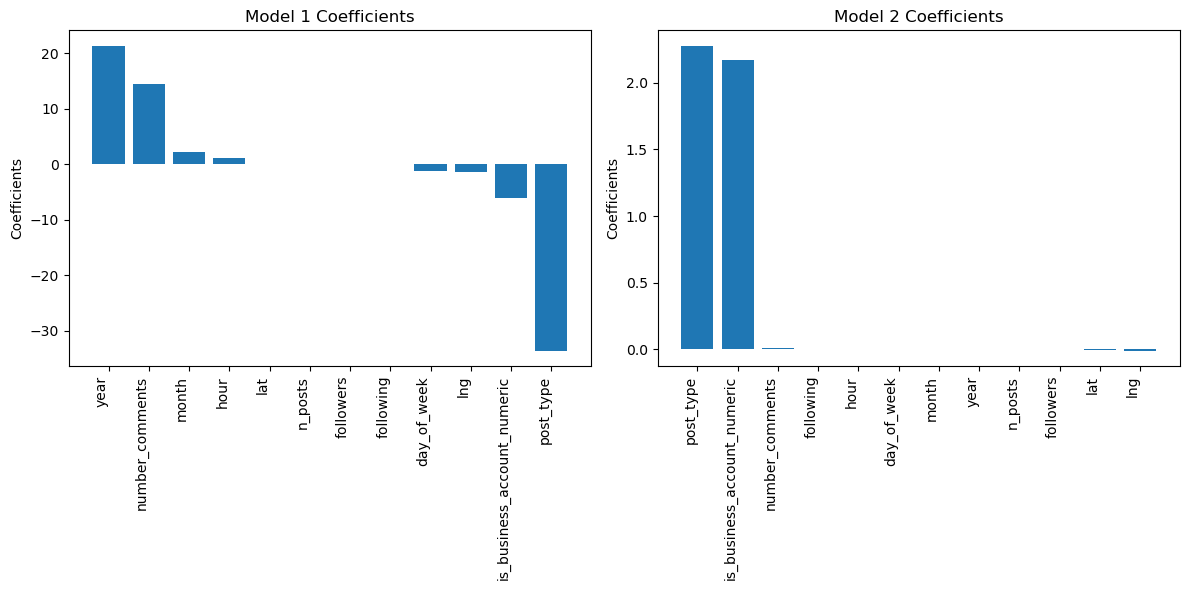

In [21]:
# Get coefficients for both models
coefficients_lr1 = lr_model1.stages[-1].coefficients.toArray()
coefficients_lr2 = lr_model2.stages[-1].coefficients.toArray()

# Define feature names
feature_names = ["post_type", "number_comments", "lat", "lng", "following", "followers", "n_posts", "is_business_account_numeric", "year", "month", "day_of_week", "hour"]

# Sort coefficients and feature names in descending order for both models
sorted_indices_lr1 = np.argsort(coefficients_lr1)[::-1]
sorted_indices_lr2 = np.argsort(coefficients_lr2)[::-1]
sorted_coefficients_lr1 = coefficients_lr1[sorted_indices_lr1]
sorted_coefficients_lr2 = coefficients_lr2[sorted_indices_lr2]
sorted_feature_names_lr1 = [feature_names[i] for i in sorted_indices_lr1]
sorted_feature_names_lr2 = [feature_names[i] for i in sorted_indices_lr2]

# Set the x-axis indices
indices = np.arange(len(feature_names))

# Create the subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the sorted coefficients for Model 1
ax1.bar(indices, sorted_coefficients_lr1)
ax1.set_title("Model 1 Coefficients")
ax1.set_xticks(indices)
ax1.set_xticklabels(sorted_feature_names_lr1, rotation=90, ha="right")
ax1.set_ylabel("Coefficients")

# Plot the sorted coefficients for Model 2
ax2.bar(indices, sorted_coefficients_lr2)
ax2.set_title("Model 2 Coefficients")
ax2.set_xticks(indices)
ax2.set_xticklabels(sorted_feature_names_lr2, rotation=90, ha="right")
ax2.set_ylabel("Coefficients")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



The left chart displays the variable coefficients for the number of likes, while the right chart shows the coefficients for the number of comments.

Regarding the number of likes, the most significant coefficient is the year of posting, indicating that newer posts tend to attract more likes due to increased exposure. Surprisingly, the second most important variable is the number of comments, which implies that higher engagement through comments can lead to more likes. The two variables with the largest negative coefficients are the business account indicator (0 for non-business and 1 for business) and the post type (1 for photo, 2 for video, 3 for multiple photos or videos). This indicates that posts from business accounts tend to have fewer likes, while longer post types, which take more time to browse, tend to receive fewer likes.

In contrast, for the number of comments, we found the opposite results. Specifically, posts from business accounts tend to receive more comments, possibly due to business owners paying people to comment or engaging with their own posts. Additionally, longer post types tend to receive more comments since they contain more information, which can stimulate discussion. These findings highlight the complex nature of social media engagement and the importance of considering multiple factors when analyzing user behavior.

## B. Profile Based Analysis

### 1. Followers

In [6]:
df.describe(["profile_id", "following", "followers"]).show()

+-------+-------------------+------------------+------------------+
|summary|         profile_id|         following|         followers|
+-------+-------------------+------------------+------------------+
|  count|           20914307|          20731142|          20731142|
|   mean|3.149608447779941E9|1371.5483954525998|  9273.35037191873|
| stddev|3.435798533313798E9| 8763.955949252335|238785.72065892594|
|    min|                  4|                 0|                 0|
|    max|        15666951479|           4191080|         285457645|
+-------+-------------------+------------------+------------------+



In [7]:
distinct_profile_count = df.agg(countDistinct("profile_id")).collect()[0][0]
distinct_profile_count

1921671

#### i. How Many Profiles Have More Than One Post

In [8]:
# Create a dataframe grouping by profile_id and count corresponding post
count_multi_profile = df.groupBy("profile_id").agg(count("post_id").alias("post_count")) \
    .filter((col("profile_id").isNotNull()) & (col("post_count") > 1)) \
    .orderBy("post_count", ascending=False)

count_multi_profile.show(10)

count_multi_profile.count()

+-----------+----------+
| profile_id|post_count|
+-----------+----------+
| 5421037289|       590|
|12878122053|       586|
|13478139882|       557|
|12961349015|       526|
| 5515448111|       440|
| 4575459348|       331|
| 4077788576|       317|
| 3672759191|       291|
| 6148875757|       286|
|  523766185|       285|
+-----------+----------+
only showing top 10 rows



1801269

In [9]:
print("Percentage of Profiles having more than one post: {:.2f}%".format(count_multi_profile.count() / distinct_profile_count * 100))

Percentage of Profiles having more than one post: 93.73%


As a matter of fact, we have more than 90% of accounts posing more than once, which indicates that most profiles are valid and active, not "zombie profiles".

#### ii. Relationship between Followers and Following

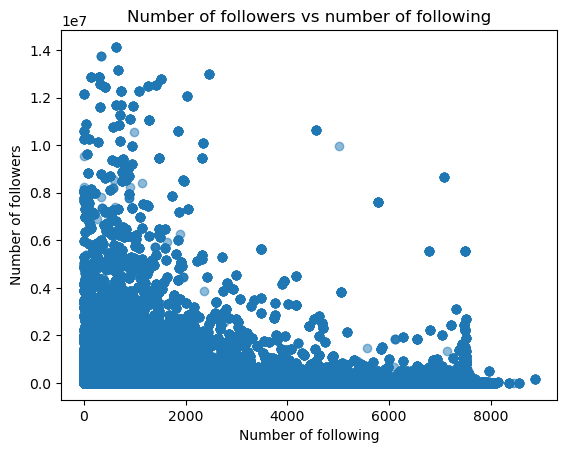

In [10]:
follower_following_df = df.select("followers", "following")\
    .dropna()\
    .filter((df.followers < 15000000) & (df.following < 10000))\
    .toPandas()

plt.scatter(follower_following_df["following"], follower_following_df["followers"], alpha=0.5)
plt.xlabel("Number of following")
plt.ylabel("Number of followers")
plt.title("Number of followers vs number of following")
plt.show()

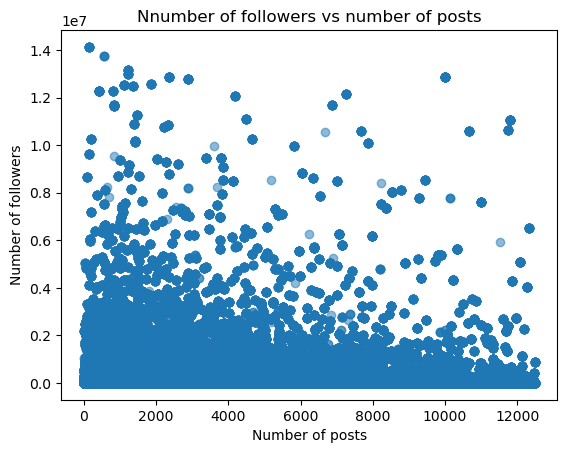

In [11]:
posts_followers_df = df.select("n_posts", "followers")\
    .dropna()\
    .filter((df.followers < 15000000) & (df.n_posts < 12500))\
    .toPandas()

plt.scatter(posts_followers_df["n_posts"], posts_followers_df["followers"], alpha=0.5)
plt.xlabel("Number of posts")
plt.ylabel("Number of followers")
plt.title("Nnumber of followers vs number of posts")
plt.show()

From the above scatterplots, we can see that within a proper range, number of followers is negatively correlated with both number of following and number of posts. The strong negative correlation between number of followers and following indicates it is not the case that the more you follow, more people would follow you. That may apply for people with a relatively small amount of associates, but for those with millions of followers, it is quite likely that the accounts they follow are just those with close relationship or with business cooperation. Afterall no celebrity follows back all their fans.
The relationship between followers and posts is a bit weaker, but is still generally negative. It shows that people can't get more followers by simply posting more, which would possibly be treated as spam accounts and attracts less followers, on the contrary.

#### iii. Linear Regression of Followers on Other Features

In [7]:
# Create a dataframe with necessary features
subset = ["profile_id", "following", "followers", "post_type", "n_posts", "is_business_account", "numbr_likes", "number_comments"]

prep_df = df.select([col(c) for c in subset]) \
            .withColumn("profile_id", col("profile_id").cast("long")) \
            .withColumn("is_business_account", col("is_business_account").cast("int")) \
            .na.drop(subset=subset)

prep_df.show(3)

+----------+---------+---------+---------+-------+-------------------+-----------+---------------+
|profile_id|following|followers|post_type|n_posts|is_business_account|numbr_likes|number_comments|
+----------+---------+---------+---------+-------+-------------------+-----------+---------------+
|5781774953|     1342|      325|        1|    157|                  0|         15|              0|
| 174304764|      723|      129|        1|    148|                  0|         26|              1|
|6665906345|      511|      137|        1|    115|                  0|         16|              1|
+----------+---------+---------+---------+-------+-------------------+-----------+---------------+
only showing top 3 rows



In [8]:
prep_df.createOrReplaceTempView("df_sql")

In [9]:
# Aggregate based on profile_id and filter outliers using SQL syntax
reg_df = spark.sql("""
select
profile_id,
avg(followers) as followers,
avg(following) as following,
count(distinct post_type) as post_type_count,
avg(n_posts) as n_posts,
avg(is_business_account) as is_business_account,
sum(numbr_likes) as sum_likes,
sum(number_comments) as sum_comments
from df_sql
group by profile_id
having avg(followers) < 50000000
""")

reg_df.describe(["followers"]).show()

+-------+-----------------+
|summary|        followers|
+-------+-----------------+
|  count|          1845454|
|   mean|7370.426400224552|
| stddev|147488.0178472723|
|    min|              0.0|
|    max|      3.5339708E7|
+-------+-----------------+



In [10]:
# Cast the categorical feature to string
reg_df = reg_df.withColumn("is_business_account", col("is_business_account").cast("string"))
reg_df.show(2)
reg_df.printSchema()

+----------+---------+---------+---------------+-------+-------------------+---------+------------+
|profile_id|followers|following|post_type_count|n_posts|is_business_account|sum_likes|sum_comments|
+----------+---------+---------+---------------+-------+-------------------+---------+------------+
|1290198567|    625.0|   2079.0|              1|  244.0|                0.0|      269|          24|
|  16986735|   1068.0|   2724.0|              1|  475.0|                0.0|       96|           1|
+----------+---------+---------+---------------+-------+-------------------+---------+------------+
only showing top 2 rows

root
 |-- profile_id: long (nullable = true)
 |-- followers: double (nullable = true)
 |-- following: double (nullable = true)
 |-- post_type_count: long (nullable = false)
 |-- n_posts: double (nullable = true)
 |-- is_business_account: string (nullable = true)
 |-- sum_likes: long (nullable = true)
 |-- sum_comments: long (nullable = true)



<AxesSubplot:>

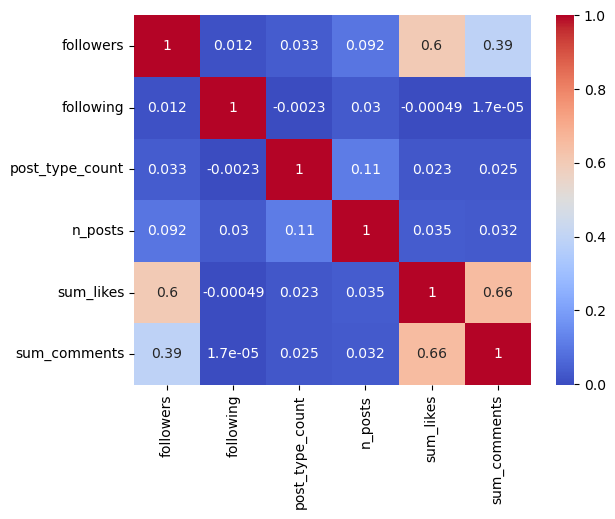

In [11]:
# Select only the relevant columns and drop "profile_id" and "is_business_account"
reg_df_corr = reg_df.select([col(c) for c in reg_df.columns if c not in ["profile_id", "is_business_account"]])

# Compute the correlation matrix
corr_matrix = reg_df_corr.toPandas().corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

As shown in the coefficients matrix, we don't have features with strong collinearity, so we would use all the features included in our linear regression.

In [12]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="followers ~ following + post_type_count+ n_posts + is_business_account + sum_likes + sum_comments")

fittedRF = supervised.fit(reg_df)  # fit the transformer

preparedDF = fittedRF.transform(reg_df)  # transform

preparedDF.select('features', 'label').show(2, False)

+--------------------------------------+------+
|features                              |label |
+--------------------------------------+------+
|[349.0,1.0,224.0,1.0,0.0,684.0,25.0]  |352.0 |
|[1377.0,1.0,1380.0,1.0,0.0,861.0,59.0]|1144.0|
+--------------------------------------+------+
only showing top 2 rows



In [13]:
# Retrieve the name of the columns
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols

,name
idx,
0,following
1,post_type_count
2,n_posts
3,is_business_account_0.0
4,is_business_account_1.0
5,sum_likes
6,sum_comments


In [14]:
# Train test split
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

In [16]:
# Fit the model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()

lrModel = lr.fit(train)

23/04/30 14:34:25 WARN org.apache.spark.ml.util.Instrumentation: [e71df212] regParam is zero, which might cause numerical instability and overfitting.
23/04/30 14:34:36 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 14:34:36 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/30 14:34:36 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/30 14:34:36 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [20]:
# Print the coefficients
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF

,coefs,name
3,-576.880155,is_business_account_0.0
0,0.177876,following
5,1.337215,sum_likes
6,3.714421,sum_comments
2,8.206043,n_posts
4,1807.718387,is_business_account_1.0
1,7563.633909,post_type_count


Text(0, 0.5, 'Beta Coefficients')

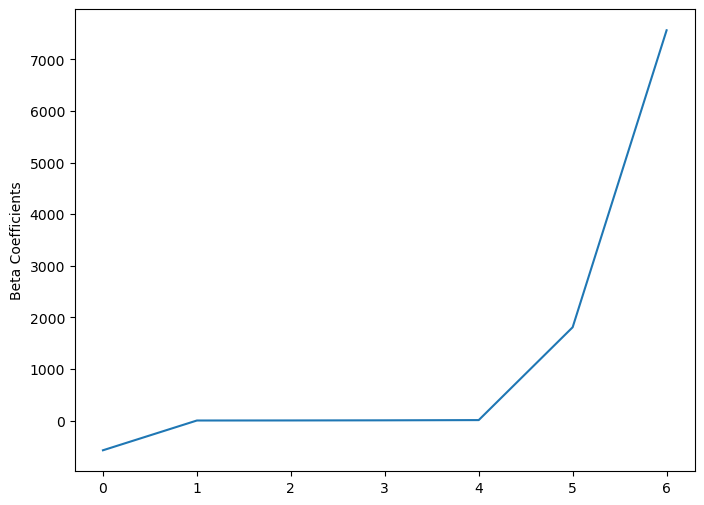

In [19]:
# Plot the coefficients to display feature importance
plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

According to the coefficients, count of different post type and being a business account or not would largely affect number of followers. Profiles with more post types and with the certification as business account would have a lot more followers specifically. Meanwhile, number of following, likes and comments seem to have less affection on number of followers.

Root Mean Squared Error (RMSE) on test data = 135222
Mean Absolute Error (MAE) on test data = 7906.89


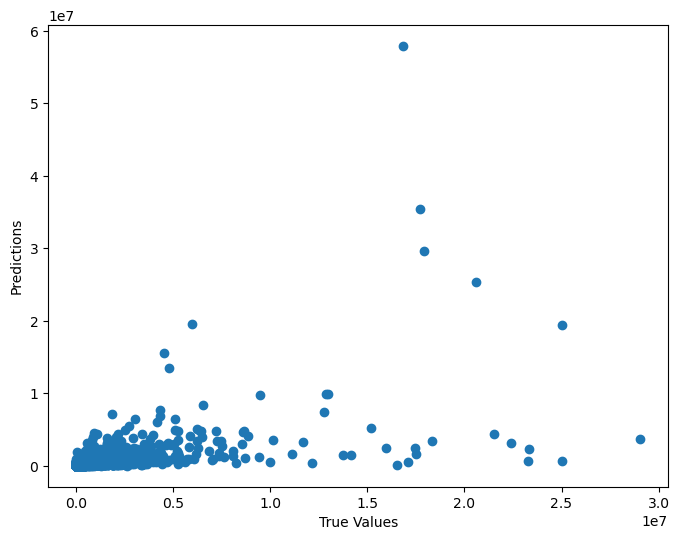

In [21]:
# Make predictions on the test data
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lrModel.transform(test)
evaluator_rmse = RegressionEvaluator(labelCol="followers", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
evaluator_mae = RegressionEvaluator(labelCol="followers", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

# Create a scatter plot of predicted vs true values
plt.scatter(predictions.select('followers').collect(), predictions.select('prediction').collect())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

As shown in the scatterplot, the linear regression model was doing okay when number of followers is smaller than 5 million, that is the points stick relatively tight with the diagonal (not 45 degree in this graph), and after that the error went larger. A possible explanation would be that 5-10 million would be a thrshould of followers for normal accounts, profiles with followers more than that would be hard to predict and serve as outliers in this example.

### 2. Country based distribution of users

In [5]:
# Copying selective columns and dropping NULL and duplicate values:

df_country = df.select("country","profile_name").drop_duplicates().dropna()

In [6]:
# Displaying first 5 rows:

df_country.head(5)

[Row(country='United Kingdom', profile_name='atikalondon'),
 Row(country='Spain', profile_name='lifeofafoodiee'),
 Row(country='United Kingdom', profile_name='eric_la_bourrique'),
 Row(country='Greece', profile_name='lyudmila0604'),
 Row(country='United States', profile_name='rachel_sawyer')]

In [7]:
# Installing wordcloud

!pip install wordcloud 

In [9]:

# Initializing stopwords
stopwords = set(STOPWORDS)

#converting list of countries in comma seperated list
d=df_country.select(col("country")).rdd.flatMap(lambda x:x[0].split(',')).collect()
text=",".join(d)

In [12]:
# Generating Word Cloud:
word_cloud = WordCloud(stopwords = stopwords,max_words=100, collocations = False, repeat = False, background_color = '#a87732', width = 5000, height = 3000)
word_cloud.generate(text)

(-0.5, 4999.5, 2999.5, -0.5)

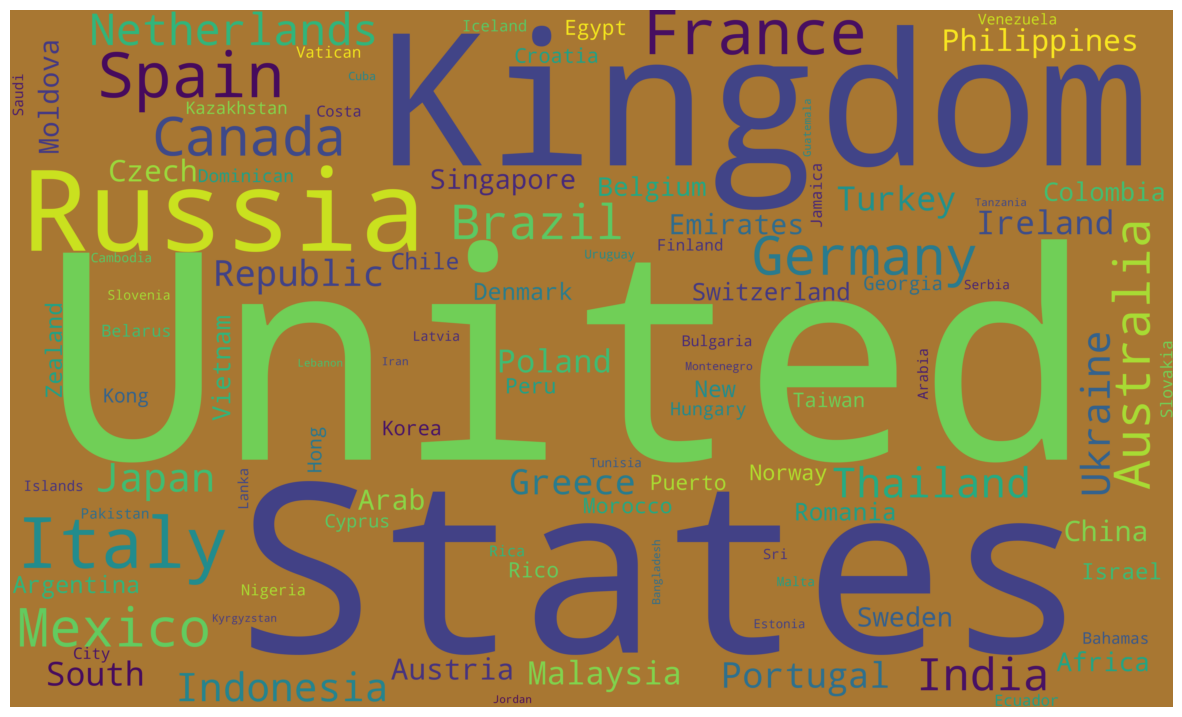

In [15]:
# Printing the word map:
fig,ax=plt.subplots(1,1,figsize=(15, 10))
ax.imshow(word_cloud, interpolation='bilinear')
ax.axis("off")

### 3. Subscribers Stickiness:

Monthly Average Users (MAU) and Daily Average Users (DAU) are important statistics for any social media platform. 

However, subscriber stickiness is an important parameter that would indicate usage-frequency of the users. In the following exercise, we are trying to determine for number of months of each user activity. This would give Instagram, an idea as to how long the users typically stay active (in months).

We did the same for weeks as well. To keep things simple, we chose month of June to see how many weeks do typically are active in a given month.

In [31]:
# Selecting only post_time and profile_name as values of interest:

df_mons = df.select("post_time","profile_name")

In [33]:
# Create a new column of month number and dropping all NULL Values:

df_mons = df_mons.withColumn('post_month', month('post_time')).dropna()

In [34]:
# Determining the size of the dataframe:

print((df_mons.count(), len(df_mons.columns)))

(20914087, 3)


In [35]:
df_mons.show(4)

+-------------------+---------------+----------+
|          post_time|   profile_name|post_month|
+-------------------+---------------+----------+
|2019-05-09 05:19:01|      bensplatt|         5|
|2019-05-05 11:42:23|_glassofbrandi_|         5|
|2019-03-04 19:07:00|  aindrealondon|         3|
|2019-03-27 12:23:33|       petersom|         3|
+-------------------+---------------+----------+
only showing top 4 rows



In [37]:
# Creating one-hot-encoder for the months but not creating vectors:

df_mons = df_mons.withColumn("Jan", when(df_mons.post_month == "1",1).otherwise(0))
df_mons = df_mons.withColumn("Feb", when(df_mons.post_month == "2",1).otherwise(0))
df_mons = df_mons.withColumn("Mar", when(df_mons.post_month == "3",1).otherwise(0))
df_mons = df_mons.withColumn("Apr", when(df_mons.post_month == "4",1).otherwise(0))
df_mons = df_mons.withColumn("May", when(df_mons.post_month == "5",1).otherwise(0))
df_mons = df_mons.withColumn("Jun", when(df_mons.post_month == "6",1).otherwise(0))
df_mons = df_mons.withColumn("Jul", when(df_mons.post_month == "7",1).otherwise(0))
df_mons = df_mons.withColumn("Aug", when(df_mons.post_month == "8",1).otherwise(0))
df_mons = df_mons.withColumn("Sep", when(df_mons.post_month == "9",1).otherwise(0))
df_mons = df_mons.withColumn("Oct", when(df_mons.post_month == "10",1).otherwise(0))
df_mons = df_mons.withColumn("Nov", when(df_mons.post_month == "11",1).otherwise(0))
df_mons = df_mons.withColumn("Dec", when(df_mons.post_month == "12",1).otherwise(0))

df_mons.show(4)

+-------------------+---------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|          post_time|   profile_name|post_month|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec|
+-------------------+---------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|2019-05-09 05:19:01|      bensplatt|         5|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|2019-05-05 11:42:23|_glassofbrandi_|         5|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|2019-03-04 19:07:00|  aindrealondon|         3|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|2019-03-27 12:23:33|       petersom|         3|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+-------------------+---------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 4 rows



In [38]:
#Aggregating the months for each userprofile:

df_month = df_mons.groupBy("profile_name") \
    .agg(sum("Jan").alias("jan_month"), \
         sum("Feb").alias("feb_month"), \
         sum("Mar").alias("mar_month"), \
         sum("Apr").alias("apr_month"), \
         sum("May").alias("may_month"), \
         sum("Jun").alias("jun_month"), \
         sum("Jul").alias("jul_month"), \
         sum("Aug").alias("aug_month"), \
         sum("Sep").alias("sep_month"), \
         sum("Oct").alias("oct_month"), \
         sum("Nov").alias("nov_month"), \
         sum("Dec").alias("dec_month") ) \
    .toPandas()

df_month.head(4)

,profile_name,jan_month,feb_month,mar_month,apr_month,may_month,jun_month,jul_month,aug_month,sep_month,oct_month,nov_month,dec_month
0,marketplacespb,0,0,0,0,6,5,0,0,0,0,0,0
1,newbalancenyc,0,0,0,9,10,0,0,0,0,0,0,0
2,cambridgeshirelive,0,1,2,0,3,0,0,0,0,0,0,0
3,slmorgan2013,0,0,0,0,4,0,0,0,0,0,0,0


In [39]:
df_month.shape

(1921650, 13)

In [41]:
# Adding an addditional column in the end to determine the number of months that user has been active:

df_month['num_months_user_active'] = 12 - (df_month == 0).sum(axis=1)

In [42]:
# Displaying first 4 rows:

df_month.head(4)

,profile_name,jan_month,feb_month,mar_month,apr_month,may_month,jun_month,jul_month,aug_month,sep_month,oct_month,nov_month,dec_month,num_months_user_active
0,marketplacespb,0,0,0,0,6,5,0,0,0,0,0,0,2
1,newbalancenyc,0,0,0,9,10,0,0,0,0,0,0,0,2
2,cambridgeshirelive,0,1,2,0,3,0,0,0,0,0,0,0,3
3,slmorgan2013,0,0,0,0,4,0,0,0,0,0,0,0,1


In [43]:
# Bringing the pandas dataframe to Spark dataframe for further processing:

df_new = spark.createDataFrame(df_month)

In [44]:
# Grouping the users count based on how many months the users are active:

df2 = df_new.groupBy("num_months_user_active").count().sort('num_months_user_active')
df2.show()

23/04/30 17:05:45 WARN org.apache.spark.scheduler.TaskSetManager: Stage 30 contains a task of very large size (10471 KiB). The maximum recommended task size is 1000 KiB.


+----------------------+------+
|num_months_user_active| count|
+----------------------+------+
|                     1|307641|
|                     2|411366|
|                     3|429255|
|                     4|334614|
|                     5|222448|
|                     6|129676|
|                     7| 59804|
|                     8| 20666|
|                     9|  5071|
|                    10|  1003|
|                    11|    97|
|                    12|     9|
+----------------------+------+



<AxesSubplot:title={'center':'Count of Subscribers for Number of Months'}, xlabel='num_months_user_active'>

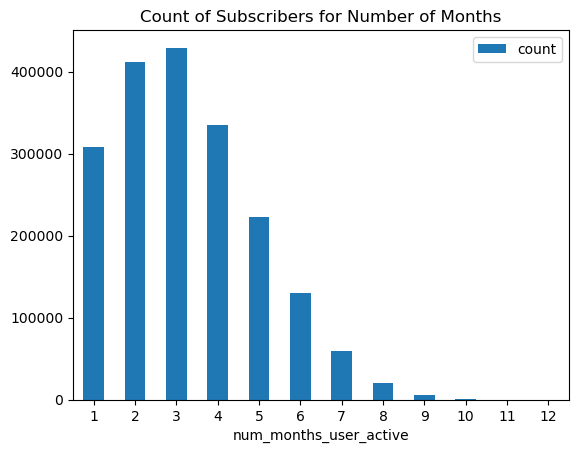

In [88]:
# Plotting the histogram:

df2.toPandas().plot.bar(x='num_months_user_active', y='count', title='Count of Subscribers for Number of Months', rot=0)

From the chart, we can see that users are typically active for about 1-4 months after which activity starts declining rapidly. Instragram needs to ensure that this typically stays high to ensure that there is high subscriber stickiness.

### 4. Weekly Subscriber Stickiness:

In [78]:
# Evaluating subscriber stickiness for weeks for singular month of June.

df_weeks = df_mons.select('post_time','profile_name').filter(df_mons['post_month'] == 6)

In [79]:
df_weeks.show(4)

+-------------------+----------------+
|          post_time|    profile_name|
+-------------------+----------------+
|2019-06-18 17:31:57|      girocycles|
|2019-06-02 20:45:15|     almondmaelk|
|2019-06-03 16:31:41|      bee_anomis|
|2019-06-11 14:54:39|volpe_sartoriale|
+-------------------+----------------+
only showing top 4 rows



In [80]:
# Inserting column for days of June month:

df_weeks = df_weeks.withColumn('post_day', dayofmonth('post_time'))
df_weeks.show(4)

+-------------------+----------------+--------+
|          post_time|    profile_name|post_day|
+-------------------+----------------+--------+
|2019-06-18 17:31:57|      girocycles|      18|
|2019-06-02 20:45:15|     almondmaelk|       2|
|2019-06-03 16:31:41|      bee_anomis|       3|
|2019-06-11 14:54:39|volpe_sartoriale|      11|
+-------------------+----------------+--------+
only showing top 4 rows



In [81]:
df_weeks = df_weeks.withColumn("1st_week", when((df_weeks.post_day >= "1") & (df_weeks.post_day < "8"),1).otherwise(0))
df_weeks = df_weeks.withColumn("2nd_week", when((df_weeks.post_day >= "8") & (df_weeks.post_day < "16"),1).otherwise(0))
df_weeks = df_weeks.withColumn("3rd_week", when((df_weeks.post_day >= "16") & (df_weeks.post_day < "22"),1).otherwise(0))
df_weeks = df_weeks.withColumn("4th_week", when(df_weeks.post_day >= "22",1).otherwise(0))

df_weeks.show(4)

+-------------------+----------------+--------+--------+--------+--------+--------+
|          post_time|    profile_name|post_day|1st_week|2nd_week|3rd_week|4th_week|
+-------------------+----------------+--------+--------+--------+--------+--------+
|2019-06-18 17:31:57|      girocycles|      18|       0|       0|       1|       0|
|2019-06-02 20:45:15|     almondmaelk|       2|       1|       0|       0|       0|
|2019-06-03 16:31:41|      bee_anomis|       3|       1|       0|       0|       0|
|2019-06-11 14:54:39|volpe_sartoriale|      11|       0|       1|       0|       0|
+-------------------+----------------+--------+--------+--------+--------+--------+
only showing top 4 rows



In [82]:
#Aggregating the weeks for each userprofile:

df_weeks_gb = df_weeks.groupBy("profile_name") \
    .agg(sum("1st_week").alias("week_1"), \
         sum("2nd_week").alias("week_2"), \
         sum("3rd_week").alias("week_3"), \
         sum("4th_week").alias("week_4")) \
    .toPandas()

df_weeks_gb.head(4)

,profile_name,week_1,week_2,week_3,week_4
0,marketplacespb,3,2,0,0
1,kateandersen06,0,3,0,0
2,ekaterina_belehova,0,1,1,7
3,2222222_na,2,1,4,2


In [83]:
# Adding an addditional column in the end to determine the number of weeks that user has been active:

df_weeks_gb['num_weeks_user_active'] = 4 - (df_weeks_gb == 0).sum(axis=1)
df_weeks_gb.head(4)

,profile_name,week_1,week_2,week_3,week_4,num_weeks_user_active
0,marketplacespb,3,2,0,0,2
1,kateandersen06,0,3,0,0,1
2,ekaterina_belehova,0,1,1,7,3
3,2222222_na,2,1,4,2,4


In [84]:
# Reconverting dataframe to Spark for further processing:

df_new2 = spark.createDataFrame(df_weeks_gb)
df_new2.show(4)

+------------------+------+------+------+------+---------------------+
|      profile_name|week_1|week_2|week_3|week_4|num_weeks_user_active|
+------------------+------+------+------+------+---------------------+
|    marketplacespb|     3|     2|     0|     0|                    2|
|    kateandersen06|     0|     3|     0|     0|                    1|
|ekaterina_belehova|     0|     1|     1|     7|                    3|
|        2222222_na|     2|     1|     4|     2|                    4|
+------------------+------+------+------+------+---------------------+
only showing top 4 rows



23/04/30 17:36:31 WARN org.apache.spark.scheduler.TaskSetManager: Stage 76 contains a task of very large size (1174 KiB). The maximum recommended task size is 1000 KiB.


In [85]:
# Grouping by number of subscribers that have been for number of weeks:

df3 = df_new2.groupBy("num_weeks_user_active").count().sort('num_weeks_user_active')
df3.show()

23/04/30 17:36:40 WARN org.apache.spark.scheduler.TaskSetManager: Stage 77 contains a task of very large size (1174 KiB). The maximum recommended task size is 1000 KiB.


+---------------------+------+
|num_weeks_user_active| count|
+---------------------+------+
|                    1|169641|
|                    2|120494|
|                    3| 94458|
|                    4| 43692|
+---------------------+------+



<AxesSubplot:title={'center':'Count of Subscribers for Number of Weeks(June)'}, xlabel='num_weeks_user_active'>

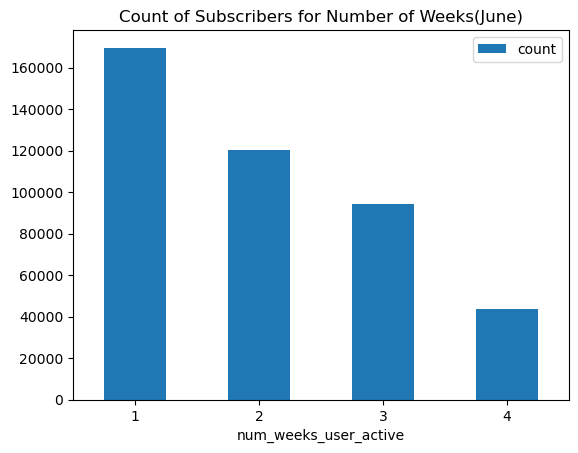

In [89]:
# Plotting the histogram:

df3.toPandas().plot.bar(x='num_weeks_user_active', y='count',title='Count of Subscribers for Number of Weeks(June)', rot=0)

Number of subscribers using instagram are highest for a single week and then seems to be tapering off, which is not a surprise. However, it is to be noted, that significant subscribers keep posting on all four weeks in a given month.

Note - There is a possibility that user might be active for the rest of the year. Here, the data is just limited to month of June. 

## C. Business Account analysis and predictions

In this part, we will analysis business account activity and try to group them into three groups using clustering. And then perform classification for Instogram. Therefore, Instogram may diliver more commercial promotions to high-quality business account. 

In [5]:
from pyspark.sql.functions import count, sum, avg, mean, round,hour, col, max, min, year, month, dayofmonth, desc, asc, collect_list,to_date,size,row_number,udf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder, StringIndexer,StandardScaler
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [6]:
df_business = df.filter('is_business_account').drop('post_type','location_description')
df_business = df_business.dropna()

### 1. Feature Engineering

We came up with two features from the original dataset: post_growth_like and post_count.<br>&nbsp;&nbsp;&nbsp;&nbsp; <1> post_growth_likem : a frequency feature that measures like growth for each profile. <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Formula: (max(post_time)'s like - min(post_time)'s like )/#posts <br>&nbsp;&nbsp;&nbsp;&nbsp; <2> post_count: number of posts each profile within same period of time.

Firstly, we create a dataframe that order posts according to the post time for each profile. Which give us a clear picture each accounts time series data over posts.

In [7]:
# create a window function to partition by profile_id and order by post_time
window = Window.partitionBy('profile_id').orderBy('post_time')

# add row numbers to the dataframe based on the window function
df_ranked = df_business.select('*', row_number().over(window).alias('row_number'))

Secondly, develop two tables from df_ranked. One called df_count, which is the denominator for our feature. Another one is df_grouped, which pick out the max post time and min post time for each profile.

In [8]:
df_count = df_ranked.groupBy('profile_id').agg(count("post_id").alias("post_count"))
df_count = df_count.select(col('profile_id').alias('profileid'), col('post_count'))

In [9]:
df_grouped = df_ranked.groupBy("profile_id", "is_business_account") \
    .agg(max("post_time").alias("max_timestamp"), min("post_time").alias("min_timestamp"), 
         collect_list("post_id").alias("post_ids"), 
         collect_list("numbr_likes").alias("num_likes"))

In [10]:
df_grouped = df_grouped.select(col('profile_id').alias('profileid'), col('max_timestamp'), col('min_timestamp'))

Then, we join tables to get df_result, which contains all parameters we want. (Last three columns)

In [11]:
df_maxtime1 = df_ranked.join(df_grouped, [(df_grouped.max_timestamp ==df_ranked.post_time) \
                                           & (df_grouped.profileid == df_ranked.profile_id)],'inner')\
.select(df_grouped.profileid.alias('profile_id'),df_ranked.post_id,df_grouped.max_timestamp, df_ranked.numbr_likes.alias('maxtime_num_like'))

df_mintime1 = df_ranked.join(df_grouped, [(df_grouped.min_timestamp ==df_ranked.post_time)\
                                           & (df_grouped.profileid == df_ranked.profile_id)],'inner')\
.select(df_grouped.profileid,df_ranked.post_id,df_grouped.min_timestamp, df_ranked.numbr_likes.alias('mintime_num_like'))

#### i. Final result dataframe

In [12]:
df_result=df_maxtime1.join(df_mintime1,df_maxtime1.profile_id==df_mintime1.profileid, "left" )
df_result = df_result.withColumn('growth',(df_result.maxtime_num_like-df_result.mintime_num_like))
df_result = df_result.drop('profileid')
df_result = df_result.join(df_count, df_count.profileid == df_result.profile_id,"left")
df_result = df_result.drop('profileid')
df_result = df_result.withColumn('post_growth_like',round((df_result.growth / df_result.post_count),2))
df_result.show()

+-----------+-----------+-------------------+----------------+-----------+-------------------+----------------+------+----------+----------------+
| profile_id|    post_id|      max_timestamp|maxtime_num_like|    post_id|      min_timestamp|mintime_num_like|growth|post_count|post_growth_like|
+-----------+-----------+-------------------+----------------+-----------+-------------------+----------------+------+----------+----------------+
| 2374974050|BxTDuaOHs3K|2019-05-10 17:52:41|             342|BxTDuaOHs3K|2019-05-10 17:52:41|             342|     0|         1|             0.0|
|  356526543|Bz0NwqRCxDj|2019-07-12 13:58:06|             106|Bxr8F6tCyrp|2019-05-20 15:49:03|             338|  -232|         8|           -29.0|
|  308264555|B0Rb8aHFoUf|2019-07-23 22:20:00|              19|Bwdx6R-Ft6W|2019-04-20 07:17:16|              43|   -24|         9|           -2.67|
| 8896790423|BzpQoN-n018|2019-07-08 07:51:31|               2|BxIKibCFg7S|2019-05-06 18:20:34|               6|    -4|

#### ii. Removing the Outliers

Give a look on the orginial results and remove outliers.

In [60]:
df_result.describe(['post_growth_like', 'post_count']).show()

+-------+------------------+-----------------+
|summary|  post_growth_like|       post_count|
+-------+------------------+-----------------+
|  count|            463167|           463167|
|   mean|-4.009018215891904|4.746618390343008|
| stddev| 1013.203956981453|4.742704699419126|
|    min|         -347921.5|                1|
|    max|          190878.0|              368|
+-------+------------------+-----------------+



In [13]:
df_result1 = df_result.filter((df_result.post_growth_like < 40000)&(df_result.post_growth_like > -40000)&(df_result.post_count<70))

After adjustment: std significantly rreduced

In [74]:
df_result1.describe(['post_growth_like', 'post_count']).show()

+-------+------------------+-----------------+
|summary|  post_growth_like|       post_count|
+-------+------------------+-----------------+
|  count|            463053|           463053|
|   mean|  -4.5010613255934|4.729709126169142|
| stddev|377.40183256888696|4.551746231270062|
|    min|          -35514.0|                1|
|    max|          37170.67|               69|
+-------+------------------+-----------------+



In [75]:
py_result = df_result1.toPandas()

#### iii. Relation between these two features

Text(0, 0.5, 'The growth of post like')

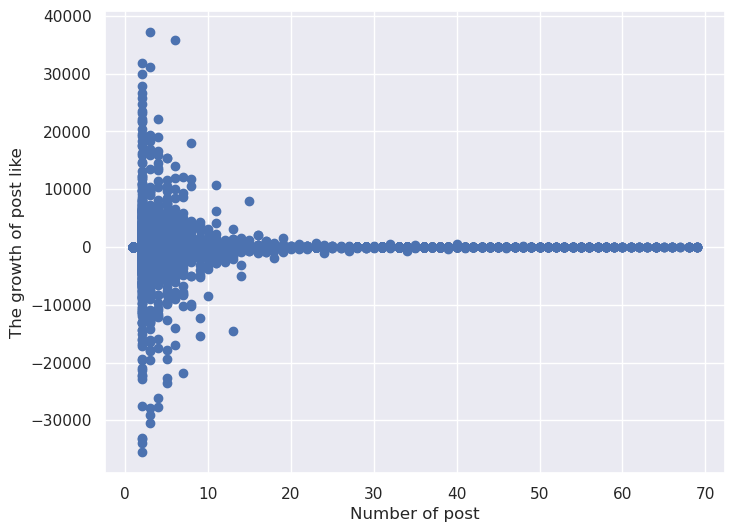

In [76]:
plt.scatter(py_result['post_count'],py_result['post_growth_like'])
plt.xlabel('Number of post')
plt.ylabel('The growth of post like')


The relationship between 'likes each post per profile' received and the 'total number of posts' of this profile have roughly followed a normal distribution. Also, the large volume of data around 0 on the y-axis reflects that most business accounts post a lot but have negligible growth in 'likes' received and sometimes have zero growth. However, many successful business accounts on the top left received many 'likes' with a limited number of posts.

### 2. K-Mean Clustering

+----------------+----------+------------+--------------------------------------------+
|post_growth_like|post_count|features    |scaledfeatures                              |
+----------------+----------+------------+--------------------------------------------+
|0.0             |1         |[0.0,1.0]   |[0.011926442685653408,-0.8194018156254828]  |
|-29.0           |8         |[-29.0,8.0] |[-0.06491473162079794,0.7184695076725222]   |
|-2.67           |9         |[-2.67,9.0] |[0.004851755258128404,0.9381654110008086]   |
|-0.25           |16        |[-0.25,16.0]|[0.011264018769218483,2.4760367342988134]   |
|-4.33           |3         |[-4.33,3.0] |[4.532604530004991E-4,-0.3800100089689099]  |
|0.0             |1         |[0.0,1.0]   |[0.011926442685653408,-0.8194018156254828]  |
|-3.5            |2         |[-3.5,2.0]  |[0.002652507855564452,-0.5997059122971964]  |
|7.0             |5         |[7.0,5.0]   |[0.03047431234583132,0.059381797687662934]  |
|24.0            |3         |[24

23/04/30 23:29:08 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 23:29:08 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Silhouette with squared euclidean distance = 0.9993520303968684
Cluster Centers: 
[-4.08692196  4.73033336]
[1.37149217e+04 3.46666667e+00]
[-1.34938752e+04  3.43801653e+00]


+----------------+----------+------------+--------------------+----------+
|post_growth_like|post_count|    features|      scaledfeatures|prediction|
+----------------+----------+------------+--------------------+----------+
|             0.0|         1|   [0.0,1.0]|[0.01192644268565...|         0|
|           -29.0|         8| [-29.0,8.0]|[-0.0649147316207...|         0|
|           -2.67|         9| [-2.67,9.0]|[0.00485175525812...|         0|
|           -0.25|        16|[-0.25,16.0]|[0.01126401876921...|         0|
|           -4.33|         3| [-4.33,3.0]|[4.53260453000499...|         0|
|             0.0|         1|   [0.0,1.0]|[0.01192644268565...|         0|
|            -3.5|         2|  [-3.5,2.0]|[0.00265250785556...|         0|
|             7.0|         5|   [7.0,5.0]|[0.03047431234583...|         0|
|            24.0|         3|  [24.0,3.0]|[0.07551913866340...|         0|
|            -2.0|         5|  [-2.0,5.0]|[0.00662705135417...|         0|
|             0.0|       

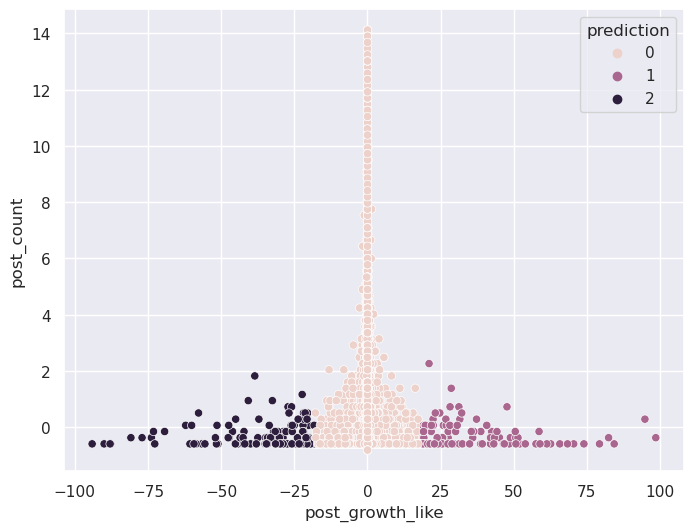

In [14]:
assembler = VectorAssembler (inputCols = ['post_growth_like','post_count'], outputCol = 'features')
output =assembler.transform(df_result1.select('post_growth_like','post_count'))
scaler = StandardScaler (inputCol = 'features', outputCol = 'scaledfeatures', withMean =True, withStd = True)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show(truncate = False)

# Trains a k-means model.
kmeans = KMeans(k=3, seed=55629)
model = kmeans.fit(scaledData)
predictions = model.transform(scaledData)


# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
    
predictions.show()

firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
scaledDF = predictions.select('prediction',firstElement('scaledfeatures').alias('post_growth_like'), secondElement('scaledfeatures').alias('post_count')).toPandas()

sns.set(rc={'figure.figsize':(8,6)})  # Figure size
sns.scatterplot(data=scaledDF, x='post_growth_like', y='post_count',hue='prediction');

According to the plot, Instogram might want to diliver more promotion to cluster 2 which are high-quality business accounts.

### 3. Random Forest Classification

From the clustering result above, we can divide business accounts into three groups and label them. And we would like to classify business accounts based on its growth of like and the number of posts by using random forest classification which reduces overfitting comparing to decision trees and helps to improve the accuracy.

In [37]:
# Creating a random forest classification model
dt1 = RandomForestClassifier(numTrees=5,
                            maxDepth=3, 
                            labelCol='label',
                            seed=42)
print(dt1.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [38]:
# Split the dataset into two groups, training dataset and testing dataset
train, test = output.randomSplit([0.7, 0.3], seed = 55629)

In [39]:
# scale training and testing datasets seperately
scaler1_train = StandardScaler (inputCol = 'features', outputCol = 'scaledfeatures', withMean =True, withStd = True)
scaler1_test = StandardScaler (inputCol = 'features', outputCol = 'scaledfeatures', withMean =True, withStd = True)

In [40]:
scalerModel_train = scaler1_train.fit(train)

In [41]:
scalerModel_test = scaler1_test.fit(test)

In [42]:
scaledData_train = scalerModel_train.transform(train)

In [43]:
scaledData_test = scalerModel_test.transform(test)

In [44]:
scaledData_train.show(5)

+----------------+----------+---------------+--------------------+
|post_growth_like|post_count|       features|      scaledfeatures|
+----------------+----------+---------------+--------------------+
|       -15380.44|         9|[-15380.44,9.0]|[-42.650654985475...|
|        -15084.5|         2| [-15084.5,2.0]|[-41.829761195076...|
|        -14348.0|         2| [-14348.0,2.0]|[-39.786819123613...|
|         -6312.5|         2|  [-6312.5,2.0]|[-17.497530576106...|
|         -6204.5|         4|  [-6204.5,4.0]|[-17.197954549333...|
+----------------+----------+---------------+--------------------+
only showing top 5 rows



In [45]:
scaledData_test.show(5)

+----------------+----------+-------------+--------------------+
|post_growth_like|post_count|     features|      scaledfeatures|
+----------------+----------+-------------+--------------------+
|         -6835.0|         2|[-6835.0,2.0]|[-16.490577922340...|
|         -4166.0|         2|[-4166.0,2.0]|[-10.046867561079...|
|         -3610.2|         5|[-3610.2,5.0]|[-8.7050113532156...|
|         -3377.5|         4|[-3377.5,4.0]|[-8.1432086551769...|
|         -2778.5|         2|[-2778.5,2.0]|[-6.6970555992026...|
+----------------+----------+-------------+--------------------+
only showing top 5 rows



In [46]:
# join the scaled features with label
fea_train_label = predictions.select(col('post_growth_like').alias('like'), \
                                     col('post_count').alias('postcount'), \
                                     col('prediction').alias('label'))
new_s_train = scaledData_train.join(fea_train_label,\
                                    [(scaledData_train.post_growth_like == fea_train_label.like)&\
                                     (scaledData_train.post_count == fea_train_label.postcount)], \
                                    'left').distinct()
new_s_test = scaledData_test.join(fea_train_label,\
                                  [(scaledData_test.post_growth_like == fea_train_label.like)&\
                                   (scaledData_test.post_count == fea_train_label.postcount)], \
                                  'inner').distinct()

In [47]:
train_input = new_s_train.select(col('scaledfeatures').alias('features'),col('label'))
test_input = new_s_test.select(col('scaledfeatures').alias('features'),col('label'))

In [48]:
# Use the training dataset to fit the model
dt_trainModel1 = dt1.fit(train_input)

In [49]:
# Use fitted model and the testing dataset to predict
rf_trainprediction = dt_trainModel1.transform(new_s_test)

In [ ]:
# Evaluating the predictions and calculating the accuracy
evaluator =MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction')
accuracy = evaluator.evaluate(rf_trainprediction)

In [ ]:
print( 'Accuracy = %s' % (accuracy))

Accuracy = 0.8786125441815131


As we can see, the accuracy of the testing dataset is higher than 80%, which indicates that the performance of the classification is reasonably good. Furthermore, it implies it could help to classify business accounts with different qualities. In terms of Instagram, this model could help them select and recommend high-quality business accounts, which post high-quality and attractive content frequently to more people, and reduce recommendations for low-quality business accounts whose posts are unattractive.

## Conclusion

Our final conclusions are as below:

- Possitive words like Thanks, Love and Life are some of the most figured keywords in the posts, and are liekly to recieve more positive feedbacks.
- Posting from uncommon countries would generally attract people's attention and recieve more likes and comments.
- People are more active in activities including likes and comments in late afternoon and evening, while are less active in the morning and late night possibly because of work and rest.
- Number of followers displays a negative correlation with both the "number of following" and the "number of posts", with the former stronger.
-  Generating more types of posts and being a business account contribute most to many followers; following more contributes the least.
-  Users are typically active for about 1-4 months, after which activity declines rapidly.
- The number of subscribers using Instagram is highest for a week and then seems to be tapering off, which is unsurprising.
- The relationship between 'like per post per profile' received and 'total number of posts in this profile roughly follows a normal distribution
- Most business accounts post a lot but have negligible growth in 'likes' received.
- We have accuracy of 85% for model to classify business acounts with different qualities.


## Challenges

As we went through the project, we encountered different challenges, including:
- Outliers can cause data to skew, so we need some regularizer to ensure outliers are appropriately addressed.
- Enormous data can often cause clusters to crash or go slow. We needed some mechanism to determine the cluster size needed to handle the data size.
- Determining the “right” model was challenging, especially for large data sizes.
- More features will improve the accuracy of the clustering results.

## Reference
- ChatGPT
- Stack Overflow